In [1]:
!nvidia-smi

Fri Apr 23 23:57:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P0    23W /  N/A |   1237MiB /  5934MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

In [3]:
import pickle # 
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('data/UNSW_NB15_training-set.csv')
data.head()

id       dur  xProt  xServ  xState  spkts  dpkts  sbytes  dbytes  \
0   1  0.121478      4    999       2      6      4     258     172   
1   2  0.649902      4    999       2     14     38     734   42014   
2   3  1.623129      4    999       2      8     16     364   13186   
3   4  1.681642      4      3       2     12     12     628     770   
4   5  0.449454      4    999       2     10      6     534     268   

        rate  ...  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
0  74.087490  ...                 1                 1               1   
1  78.473372  ...                 1                 1               2   
2  14.170161  ...                 1                 1               3   
3  13.677108  ...                 1                 1               3   
4  33.373826  ...                 2                 1              40   

   is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  \
0             0           0                 0           1           1   
1             0           0                 0           1           6   
2             0           0                 0           2           6   
3             1           1                 0           2           1   
4             0           0                 0           2          39   

   is_sm_ips_ports  label  
0                0      0  
1                0      0  
2                0      0  
3                0      0  
4                0      0  

[5 rows x 44 columns]

In [5]:
X = data.iloc[: , :-1].values
X.shape

(175341, 43)

In [6]:
attacks = list(pd.unique(data["label"]))
attacks

[0, 1]

In [7]:
y = np.array(list(map((lambda x: attacks.index(x)), data.iloc[: , -1].values)))
y.shape

(175341,)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, y_train.shape, y_test.shape

((140272, 43), (140272,), (140272,), (35069,))

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

------------------------------------------------------------------------------------------------------------------

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [11]:
class UNSW_NB15(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [12]:
train_data = UNSW_NB15(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = UNSW_NB15(torch.Tensor(X_test), torch.Tensor(y_test))

In [13]:
bs = 256

train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=bs)

In [14]:
len(train_loader.dataset)//bs + 1, len(test_loader.dataset)//bs + 1

(548, 137)

In [25]:
class Teacher(nn.Module):

    def __init__(self, n_features, n_classes):
        super(Teacher, self).__init__()

        self.mlp = nn.Sequential(*[
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, n_classes)
        ])

    def forward(self, x):
        return self.mlp(x)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
teacher = Teacher(X_train.shape[1], len(attacks)).to(device)
teacher

Teacher(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [28]:
sum(p.numel() for p in teacher.parameters())

2090

In [29]:
loss_fn = nn.CrossEntropyLoss()
teacher_optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9)

In [35]:
def accuracy(preds, labels):
        
    preds = F.softmax(preds, dim=1).argmax(dim=1)
    n_correct = (preds==labels).sum().float()
    
    return (n_correct/len(labels)).item()
    

In [17]:
n_epochs = 50

Epoch 1: Loss = 151.16069880872965, Average epoch accuracy = 0.8721862645262349
Epoch 6: Loss = 57.062370870262384, Average epoch accuracy = 0.9556588352161602
Epoch 11: Loss = 43.7031656447798, Average epoch accuracy = 0.9691011824094466
Epoch 16: Loss = 38.369906889274716, Average epoch accuracy = 0.9715204913250721
Epoch 21: Loss = 34.441613893955946, Average epoch accuracy = 0.9735985972585469
Epoch 26: Loss = 31.814491564407945, Average epoch accuracy = 0.9755769085927601
Epoch 31: Loss = 30.927478331141174, Average epoch accuracy = 0.9766095461201494
Epoch 36: Loss = 29.375940441153944, Average epoch accuracy = 0.9774592268640978
Epoch 41: Loss = 28.71140925306827, Average epoch accuracy = 0.9782837211650653
Epoch 46: Loss = 28.247326182201505, Average epoch accuracy = 0.9784704799199626


Text(0, 0.5, 'Loss')

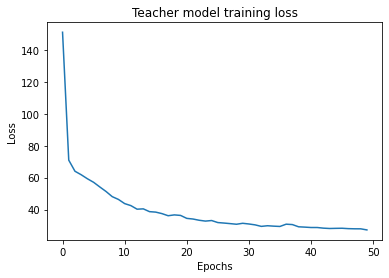

In [22]:
epoch_losses = []
epoch_accuracies = []

for e in range(n_epochs):
    running_loss = 0
    batch_accuracies = []
    
    for i, (data, labels) in enumerate(train_loader):
        
        teacher_optimizer.zero_grad()
        
        data, labels = data.to(device), labels.to(device).long()
        preds = teacher(data)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        teacher_optimizer.step()
        
        running_loss += loss.item()
        batch_accuracies.append(accuracy(preds, labels))
        
#         if i%50==0:
#             print(f"Average accuracy = {sum(batch_accuracies)/len(batch_accuracies)}")
    
    epoch_losses.append(running_loss)
    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
    
    if (e%5 == 0):
        print(f"Epoch {e+1}: Loss = {epoch_losses[e]}, Average epoch accuracy = {epoch_accuracies[e]}")

plt.plot(epoch_losses)
plt.title("Teacher model training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [23]:
accuracies = []
for data, labels in test_loader:
    
    data, labels = data.to(device), labels.to(device)
    preds = teacher(data)
    accuracies.append(accuracy(preds, labels))
print(f"Average accuracy = {sum(accuracies)/len(accuracies)}")

Average accuracy = 0.9792128357574017


In [30]:
class Student(nn.Module):

    def __init__(self, n_features, n_classes):
        super(Student, self).__init__()

        self.mlp = nn.Sequential(*[
            nn.Linear(n_features, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, n_classes)
        ])

    def forward(self, x):
        return self.mlp(x)

In [31]:
student = Student(X_train.shape[1], len(attacks)).to(device)
student

Student(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [32]:
sum(p.numel() for p in student.parameters())

886

In [33]:
loss_fn = nn.CrossEntropyLoss()
student_optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9)

Epoch 1: Loss = 149.11810640990734, Average epoch accuracy = 0.8772420544911476
Epoch 6: Loss = 59.70849706232548, Average epoch accuracy = 0.9532100632242912
Epoch 11: Loss = 54.02267661318183, Average epoch accuracy = 0.9587372643669156
Epoch 16: Loss = 48.8747996725142, Average epoch accuracy = 0.963798281702682
Epoch 21: Loss = 44.89717271924019, Average epoch accuracy = 0.966419556062587
Epoch 26: Loss = 42.16798575408757, Average epoch accuracy = 0.969295069249007
Epoch 31: Loss = 38.41551203094423, Average epoch accuracy = 0.9713427616949499
Epoch 36: Loss = 36.38752746582031, Average epoch accuracy = 0.9724257718907655
Epoch 41: Loss = 37.05505560152233, Average epoch accuracy = 0.9717200807411305
Epoch 46: Loss = 34.956634597852826, Average epoch accuracy = 0.9732027449747072


Text(0, 0.5, 'Loss')

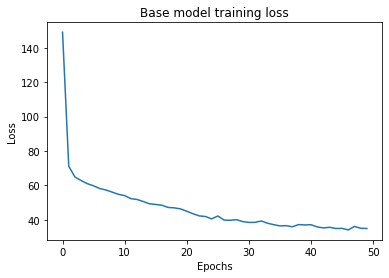

In [36]:
epoch_losses = []
epoch_accuracies = []

for e in range(n_epochs):
    running_loss = 0
    batch_accuracies = []
    
    for i, (data, labels) in enumerate(train_loader):
        
        student_optimizer.zero_grad()
        
        data, labels = data.to(device), labels.to(device).long()
        preds = student(data)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        student_optimizer.step()
        
        running_loss += loss.item()
        batch_accuracies.append(accuracy(preds, labels))
        
#         if i%50==0:
#             print(f"Average accuracy = {sum(batch_accuracies)/len(batch_accuracies)}")
    
    epoch_losses.append(running_loss)
    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
    
    if (e%5 == 0):
        print(f"Epoch {e+1}: Loss = {epoch_losses[e]}, Average epoch accuracy = {epoch_accuracies[e]}")

plt.plot(epoch_losses)
plt.title("Base model training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [37]:
accuracies = []
for data, labels in test_loader:
    
    data, labels = data.to(device), labels.to(device)
    preds = student(data)
    accuracies.append(accuracy(preds, labels))
    
print(f"Average accuracy = {sum(accuracies)/len(accuracies)}")

Average accuracy = 0.9719705912318543


In [30]:
student = Student(X_train.shape[1], len(attacks)).to(device)
student

Student(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [31]:
student_optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9)

Epoch 1: Loss = 58.45153899490833, Average epoch accuracy = 0.9224614127926583
Epoch 6: Loss = 22.288718381896615, Average epoch accuracy = 0.9679749278474028
Epoch 11: Loss = 19.086903229355812, Average epoch accuracy = 0.9712548472367935
Epoch 16: Loss = 17.6185175543651, Average epoch accuracy = 0.9733243994686726
Epoch 21: Loss = 16.92204988375306, Average epoch accuracy = 0.9745552007951875
Epoch 26: Loss = 16.16595064336434, Average epoch accuracy = 0.9753321738791292
Epoch 31: Loss = 15.953722719103098, Average epoch accuracy = 0.9756895339619505
Epoch 36: Loss = 15.68081203661859, Average epoch accuracy = 0.9758411269553386
Epoch 41: Loss = 15.395040223374963, Average epoch accuracy = 0.9766675221876506
Epoch 46: Loss = 15.195857577957213, Average epoch accuracy = 0.9770168036657528


Text(0, 0.5, 'Loss')

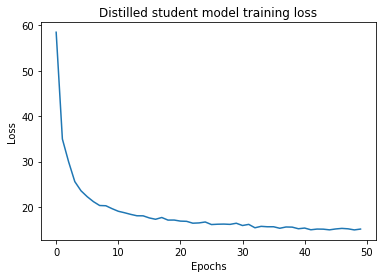

In [32]:
distil_weight = 0.5

epoch_losses = []
epoch_accuracies = []

for e in range(n_epochs):
    running_loss = 0
    batch_accuracies = []
    
    for i, (data, labels) in enumerate(train_loader):
        
        student_optimizer.zero_grad()
        
        data, labels = data.to(device), labels.to(device).long()
        student_preds = student(data)
        loss = (1-distil_weight) * loss_fn(student_preds, labels)
        
        teacher_preds = teacher(data)
        soft_student_probs = F.log_softmax(student_preds/10, dim=1)
        soft_teacher_probs = F.softmax(teacher_preds/10, dim=1)
        loss += distil_weight * F.kl_div(soft_student_probs, soft_teacher_probs.detach(), reduction='batchmean')
        
        loss.backward()
        student_optimizer.step()
        
        running_loss += loss.item()
        batch_accuracies.append(accuracy(student_preds, labels))
        
#         if i%50==0:
#             print(f"Average accuracy = {sum(batch_accuracies)/len(batch_accuracies)}")
    
    epoch_losses.append(running_loss)
    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
    
    if (e%5 == 0):
        print(f"Epoch {e+1}: Loss = {epoch_losses[e]}, Average epoch accuracy = {epoch_accuracies[e]}")

plt.plot(epoch_losses)
plt.title("Distilled student model training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [33]:
accuracies = []
for data, labels in test_loader:
    
    data, labels = data.to(device), labels.to(device)
    preds = student(data)
    accuracies.append(accuracy(preds, labels))
    
print(f"Average accuracy = {sum(accuracies)/len(accuracies)}")

Average accuracy = 0.9758483284581316


In [34]:
sum(p.numel() for p in student.parameters())

886